## The Impact of Intermediate Dimensionality on the Clustering Coherence of News Embeddings using HDBSCAN
---
This notebook evaluates clustering pipelines for news article embeddings by systematically varying intermediate dimensionality reduction and measuring cluster coherence, coverage, and stability. We show that clustering quality is highly sensitive to the reduced dimension and that stable, interpretable trends emerge only within a narrow range of pipeline configurations.

In [1]:
# Standard Library
import uuid
import ast
import itertools

# Data Handling & Science
import pandas as pd
import numpy as np

# Dimensionality & Clustering
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
import umap
import hdbscan

# Metrics
from sklearn.metrics import adjusted_rand_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Misc
import warnings
warnings.filterwarnings("ignore", message=".*n_jobs value 1 overridden.*")

seed:int = 67

/Users/evansun/Desktop/sr/sr_data_analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Introduction
---
Recent progress in transformer-based language models has made it straightforward to represent large collections of text as high-dimensional semantic embeddings. Because these embeddings are often massive (over 3,000 dimensions), we rarely cluster them directly. Instead, we use "intermediate" steps to shrink the data down before grouping it.

Why do we do this? Direct clustering in high dimension is hindered by _distance concentration_. Geometrically, as dimensionality increases, the contrast between the distance to the nearest and farthest neighbors diminishes. Density-based algorithms like [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) identifies clusters by evaluating the distance and connectivity of a Minimum Spanning Tree. This 'flatness' in distance prevents the algorithm from distinguishing between dense topical cores and the sparse background noise. Intermediate dimensionality reduction serves to __restore the local density contrast__ necessary for HDBSCAN’s reachability metrics to function.

In most data pipelines, developers use Principal Component Analysis (PCA) or Uniform Manifold Approximation and Projection (UMAP) to handle this shrinkage. While PCA is a classic, linear approach that focuses on broad patterns, UMAP is a modern, non-linear method designed to keep related items close together. Chosing a dimension reduction algorithm is one thing, but which intermediate dimension is optimal for clustering?

This choice is especially important for Hierarchical Density-Based Spatial Clustering of Applications with Noise(HDBSCAN), a clustering algorithm that groups data based on how "dense" it is. Because the very concept of "density" changes depending on how many dimensions you have, the intermediate step isn't just a technicality—it might completely change which news stories get grouped together and which are thrown out as "noise."

### The Goal
---
I'm particularly intrested in using HDBSCAN for automating trend detection in news for a digestive reading app called SightRead. Through this project I hope to learn more about the tradeoffs in choosing a clustering pipeline, and simply document findings. 

In this work, I explore how changing the number of intermediate dimensions for both PCA and UMAP affects the final quality of news clusters. By testing a range of dimensions, I aim to measure:

__Cluster Coherence__: How semantically similar are the articles within a single group?

__Noise Levels__: How much of our data is discarded as "un-clusterable" in different dimensions?

__Method Comparison__: Does UMAP’s non-linear approach actually produce better clusters for news than the simpler PCA method?

By analyzing embeddings from RSS news feeds, I hope to provide a practical guide for which dimensionality reduction settings actually work best for organizing the daily news.

### An Overview of Data Collection
---
I'll give a quick overview of where and how the data is collected, more information on the dataset can be found [here](https://github.com/evansun06/trend-analysis-sr/blob/main/wrangling.ipynb). Articles were polled for a 1-week window from January 5th to January 12th from a select subset of RSS feeds from _The Guardian_, _The Wall Street Journal_, _United Nations_, _Fox News_, and _Daily Mail_.

<p align="center">
	<img src="assets/rss_aggregation.png" alt="Data aggregation diagram" width="720" />
</p>

_figure: SightRead RSS aggregation workflow_



### Dataset overview

__Fields__ (post-wrangling):
1. article_id: UUID for a unique article.
2. normalized_text: Headline concatenated with description, normalized.
3. polled_at: timestamp when the article was polled at (each RSS feed was polled by the hour)
4. published_at: the publication date of the article for possible time series analysis
5. embedding: the embedding vector (OpenAI text-embedding-3-large)

*_see `wrangling.ipynb` for wrangling procedures_

In [2]:
df = pd.read_csv("data/wrangled_articles.csv")
df.head()

,article_id,normalized_text,polled_at,published_at,embedding
0,d9509dc9-a405-4866-9201-19e3d063d137,Outrage as 'miserable' shovel-wielding neighbo...,2026-01-07 13:33:24.714064+00,2026-01-07 13:29:24+00,"[-0.011435215,-0.03746951,-0.0075333593,-0.026..."
1,9a156ce2-11d6-4eff-b243-e2d2bb208faa,"Morality, military might and a sense of mischi...",2026-01-09 05:17:56.535446+00,2026-01-09 03:15:08+00,"[0.0061512175,-0.03799464,-0.016263446,-0.0129..."
2,df3b2fc9-4d0f-4199-bca1-ea6d954e0c31,Republican senator vows to block all Fed nomin...,2026-01-12 15:17:02.967673+00,2026-01-12 14:55:53+00,"[-0.0072780806,-0.023142586,-0.021380594,0.020..."
3,d0f6077e-15be-497e-9a2b-1c023486ce9a,Starmer prepares to rip up Brexit: PM ready to...,2026-01-05 04:42:39.19293+00,2026-01-04 15:49:23+00,"[0.018081628,0.02099675,-0.010544334,0.0247128..."
4,847a6cef-0c95-4a0f-9388-7345ba01bf26,ANOTHER poll shows Labour in third behind Refo...,2026-01-07 11:12:56.5161+00,2026-01-07 10:57:35+00,"[0.032669835,-0.002811013,-0.012023548,-0.0104..."


## Part I: The Effect of Intermediate Dimensionality on the Cluster Quality of HDBSCAN with respect to PCA and UMAP

The goal: In this section we'll explore and compare the effect of clustering with HDBSCAN in an particular intermediate dimension, $d$, on cluster coherence. We'll observe the effect under two pipelines which use UMAP and PCA to reduce dimensionality, respectively.


Let us first define our embedding data mathematically:

Let $N$ be the number of news articles contained in the dataset. Each article $i$ is represented by an embedding vector where $D$ is the embedding space (3072).

$$
x_i \in \mathbb{R}^D
$$



We stack embeddings into a matrix $X \in \mathbb{R}^{D\times N}$ where

$$

X = \begin{bmatrix} x_1^{\top} \\ x_2^{\top} \\ \vdots \\ x_N^{\top}\end{bmatrix} \in \mathbb{R}^{N \times D}

$$

In [3]:
# Stack raw embeddings into D x N numpy matrix
df['embedding'] = df['embedding'].apply(ast.literal_eval)
X_raw = np.vstack(df['embedding'].values)

# L2 Normalize
X_norm = Normalizer(norm='l2').fit_transform(X_raw)

# Append original dataset for later reference
df['embedding_norm'] = list(X_norm)

Below we define the two clustering piplines

__Pipeline A: Unifold Manifold Approximation with Projection__

1. L2 Normalization (scikit-learn)

$$\hat{X} = \{ \hat{x}_1, \hat{x}_2, \dots, \hat{x}_n \}^\top \quad \text{where} \quad \hat{x}_i = \frac{x_i}{\|x_i\|_2}$$

2. Reduce to intermediate dimension via PCA
$$
    {PCA}_{(d)}: \mathbb{R}^D \rightarrow \mathbb{R}^d
$$

$$
    \hat{X} \rightarrow Z^{(pca)}_d,\ \ \  Z^{(pca)}_d\in \mathbb{R}^{N \times d}
$$

3. Cluster using HDBSCAN with variated hyperparameters
    - `min_cluster_size`
    - `min_samples`
    - `output`: Assigns each article $i$ with label $\ell_i \in \{-1, 0, 1, ..., K-1\}$ where -1 is noise


__Pipeline B: Principle Component Analysis__

_Repeat with UMAP_
$$
{UMAP}_{(d)}: \mathbb{R}^D \rightarrow \mathbb{R}^d
$$

$$
    \hat{X} \rightarrow Z^{(umap)}_d,\ \ \  Z^{(umap)}_d\in \mathbb{R}^{N \times d}
$$

In [4]:
### Pipeline Helper Implemntation

def cluster_hdbscan(mcs: int, ms: int, Z):
    """
    Use HDBSCAN to clusters the reduced embeddings

    args: 
        - mcs: minimum cluster size
        - ms: minimum samples
        - Z: the reduced embeddings matrix
    
    returns:
        - labels: {-1, 0, ..., K - 1}
    """

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size= mcs,
        min_samples= ms,
        metric="euclidean"
    )   

    return clusterer.fit_predict(Z)


def reduce_umap(d: int, X_hat):
    """
    Reduce embedding matrix to desired intermediate space via UMAP

    args: 
        - d: intermediate dimension
        - X_hat: normalized embeddings in original space

    returns:
        - Z_umap: matrix containing the reduced embeddings
    """

    # UMAP config for clustering (Heuristic Heavy)
    reducer = umap.UMAP(
        n_components=d, 
        n_neighbors=30,
        min_dist=0.0, 
        metric="cosine", 
        random_state=seed,
        n_jobs=-1
    )

    return reducer.fit_transform(X_hat)
    

def reduce_pca(d: int, X_hat):
    """
    Reduce embedding matrix to desired intermediate space via PCA

    args: 
        - d: intermediate dimension
        - X_hat: normalized embeddings in original space

    returns:
        - Z_pca: matrix containing the reduced embeddings
    """
    
    reducer = PCA(
        n_components=d,
        random_state=seed
    )

    return reducer.fit_transform(X_hat)


### Variables

__Pipeline configurations__ $(d, {mcs}, {ms})$:
- intermediate dimension $d \in \{2, 3, 5, 10, 15, 25, 35, 50, 75, 100, 500\}$
    - covers a range of interesting dimensions including heuristic sweetspots (10-50) and pitfall ranges (100+)
- min_cluster_size(mcs): HDBSCAN hyperparameter $\{5, 10, 25, 50\}$
    - minimum size HDBSCAN will consider a legitimate, independent cluster rather than noise
- min_samples(ms): HDBSCAN hyperparameter $\{1, 5, 15, 30\}$
    - defines how many neighbors a point must have to be considered a "core" part of a dense region

We'll compare a grid of min_cluster_size and min_samples as these hyperparameters are highly effected by dimensionality

In [59]:
d_values = [2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 181, 256, 362, 512]
mcs_values = [5, 10, 25, 50]
ms_values = [1, 5, 15, 30]

With context and setup in place! Lets get some results!

In [61]:
all_results = []
article_ids = df['article_id'].values 

for pipeline_name, reducer_func in [('UMAP', reduce_umap), ('PCA', reduce_pca)]:

    for d in d_values:
        # Step 1: Reduce once per dimension d
        Z = reducer_func(d, X_norm)
        
        for mcs in mcs_values:
            for ms in ms_values:

                # Step 2: Cluster
                labels = cluster_hdbscan(mcs, ms, Z)
                
                # Create a temporary DataFrame for this specific run
                run_df = pd.DataFrame({
                    'article_id': article_ids,
                    'cluster_label': labels
                })
                
                # Assign the constants for this run
                run_df['pipeline'] = pipeline_name
                run_df['d'] = d
                run_df['mcs'] = mcs
                run_df['ms'] = ms
                
                all_results.append(run_df)

# Final squash: concat is very efficient for a list of DataFrames
results_df = pd.concat(all_results, ignore_index=True)

In [ ]:
#results_df.to_csv('data/grid_search_results.csv', index=False)

In [5]:
# inspect

results_df = pd.read_csv("data/grid_search_results.csv")
len(results_df)


1814784

### Clustering Verification

Before we dive deeper into metrics and analysis, lets get a visual confirmation of our clusters! On a whim i'll choose the configuration `(d = 50, mcs = 10, ms =5)` and hope they give us some cool early visuals!

In [6]:
umap_filtered = (
    results_df
    .query("d == 48 & mcs == 10 & ms == 5 & pipeline == 'UMAP'")
    .filter(items=['article_id', 'cluster_label'])
)

pca_filtered = (
    results_df
    .query("d == 48 & mcs == 10 & ms == 5 & pipeline == 'PCA'")
    .filter(items=['article_id', 'cluster_label'])
)

####Setup Visual Reduction to 2D 

umap_2d = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    metric="cosine",
    random_state=seed
)

pca_2d = PCA(
    n_components=2, 
    random_state=seed
)

Z_2d_umap = umap_2d.fit_transform(X_norm)
Z_2d_pca = pca_2d.fit_transform(X_norm)

test_visuals = pd.DataFrame({
    'label_umap': pca_filtered['cluster_label'].values,
    'label_pca': umap_filtered['cluster_label'].values,
    'umap_x': Z_2d_umap[:, 0],
    'umap_y': Z_2d_umap[:, 1],
    'pca_x': Z_2d_pca[:, 0],
    'pca_y': Z_2d_pca[:, 1]
})

test_visuals.head()


,label_umap,label_pca,umap_x,umap_y,pca_x,pca_y
0,-1,-1,10.696124,0.259022,-0.171093,0.109369
1,18,-1,8.877758,5.687928,0.520753,-0.113530
2,-1,-1,9.525983,4.987135,0.113202,0.031635
3,19,62,9.146717,3.565123,0.041096,-0.212573
4,19,62,9.156141,3.347402,-0.056044,-0.172948


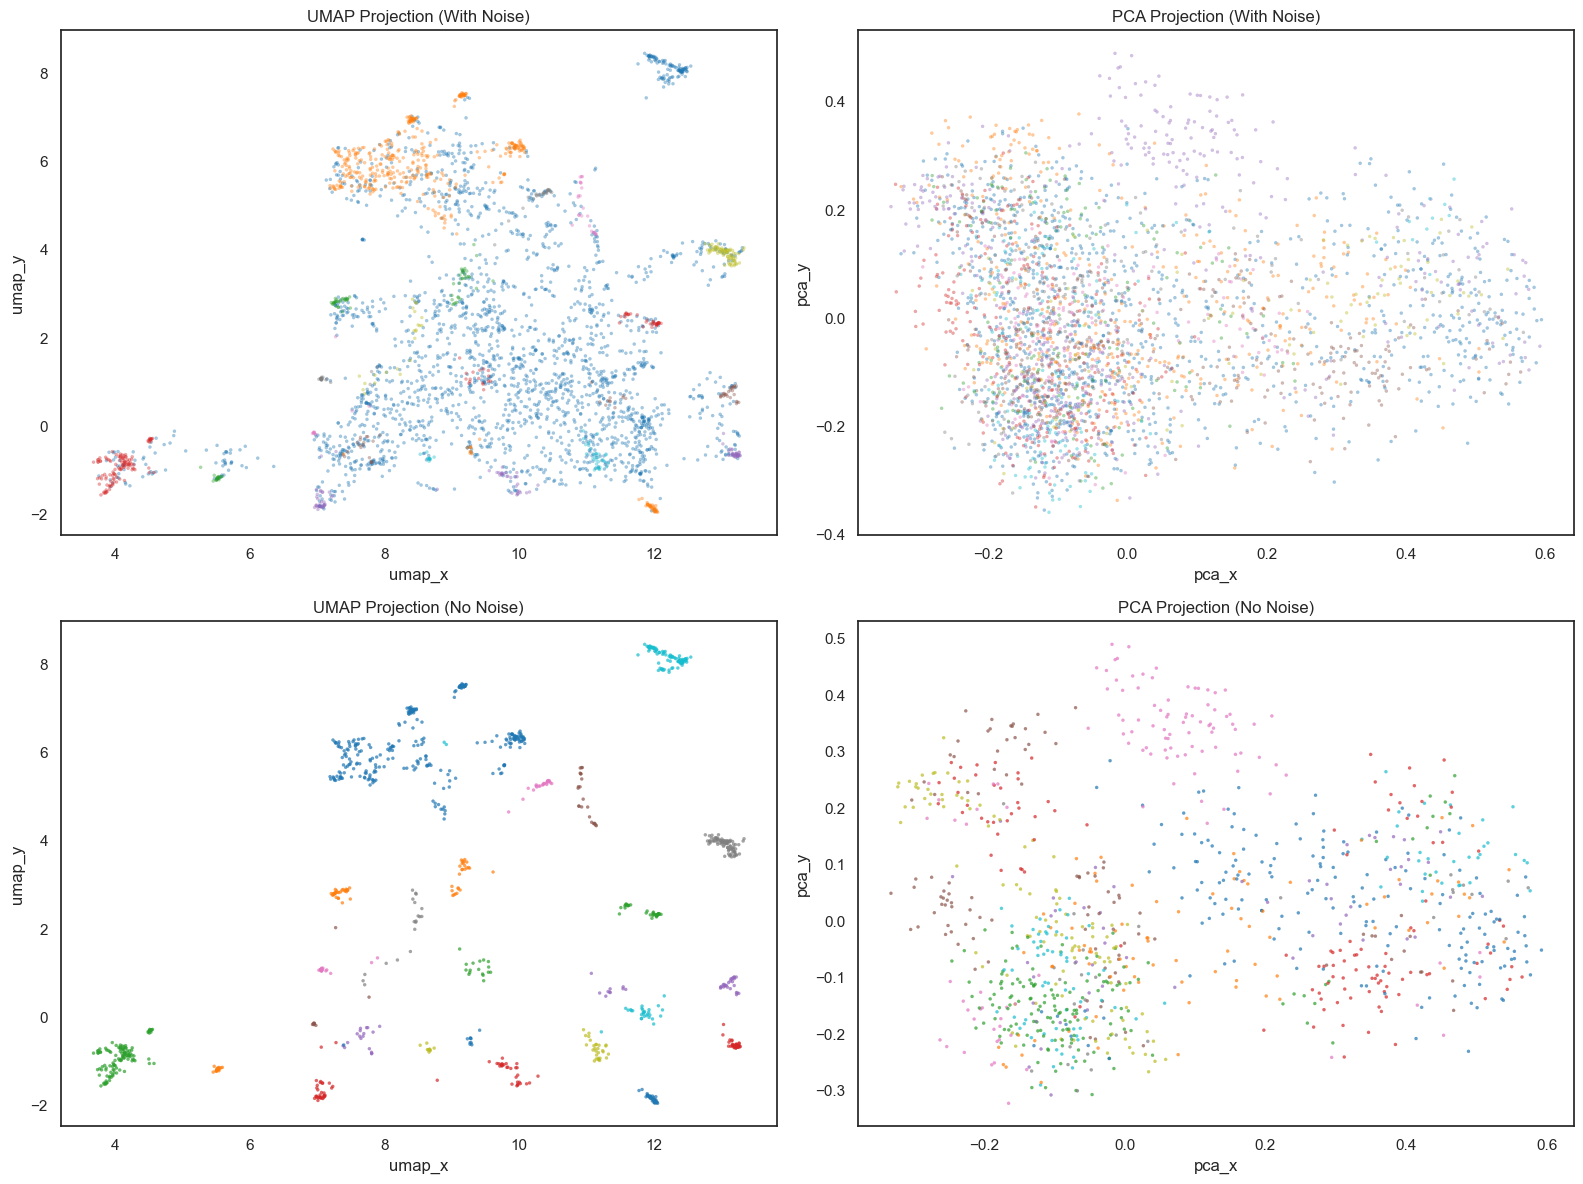

In [7]:
# 1. Prepare the data
# Create a string version for categorical plotting
test_visuals['label_umap'] = test_visuals['label_umap'].astype(str)
test_visuals['label_pca'] = test_visuals['label_pca'].astype(str)

# Create a filtered version for the "No Noise" row
# (Assuming '-1' is the string label for noise)
no_noise_df = test_visuals[
    (test_visuals['label_umap'] != '-1') & 
    (test_visuals['label_pca'] != '-1')
].copy()

sns.set_theme(style="white")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- ROW 1: WITH NOISE ---

# Plot 1: UMAP with Noise
sns.scatterplot(
    ax=axes[0, 0], data=test_visuals.sort_values('label_umap'),
    x='umap_x', y='umap_y', hue='label_umap',
    palette='tab10', alpha=0.4, s=5, edgecolor=None, legend=False
)
axes[0, 0].set_title('UMAP Projection (With Noise)')

# Plot 2: PCA with Noise
sns.scatterplot(
    ax=axes[0, 1], data=test_visuals.sort_values('label_pca'),
    x='pca_x', y='pca_y', hue='label_pca',
    palette='tab10', alpha=0.4, s=5, edgecolor=None, legend=False
)
axes[0, 1].set_title('PCA Projection (With Noise)')

# --- ROW 2: NO NOISE ---

# Plot 3: UMAP without Noise
sns.scatterplot(
    ax=axes[1, 0], data=no_noise_df.sort_values('label_umap'),
    x='umap_x', y='umap_y', hue='label_umap',
    palette='tab10', alpha=0.7, s=5, edgecolor=None, legend=False
)
axes[1, 0].set_title('UMAP Projection (No Noise)')

# Plot 4: PCA without Noise
sns.scatterplot(
    ax=axes[1, 1], data=no_noise_df.sort_values('label_pca'),
    x='pca_x', y='pca_y', hue='label_pca',
    palette='tab10', alpha=0.7, s=5, edgecolor=None, legend=False
)
axes[1, 1].set_title('PCA Projection (No Noise)')

plt.tight_layout()
plt.show()

## Model Evaluation & Cluster Validation
---

Now that we have generated cluster assignments using our respective PCA and UMAP pipelines, we'll grade each pipeline configuration on these metrics:

### 1. Weighted Clustering Coherence

Summary: The average cosine simlarity of every point in a cluster with their cluster centroid, averaged and weighted for all clusters $k \in \{0, 1, ..., K - 1\}$

_To formalize:_


For each cluster $k \in \{0, ..., K-1\}$, let $S_k$ be the set of all articles $i$ grouped within cluster $k$, and $n_k = |S_k|$

__1.1__ Compute the centroid (mean embedding):

$$
    \mu_k = \frac{1}{n_k}\sum_{i \in S_k}{\hat{x}_i}

$$

__1.2__ Normalize the centroid

$$
    \hat{\mu}_k = \frac{\mu_k}{||\mu_k||_2}

$$

__1.3__ Compute cluster coherence score

For each article $i$ in the cluster, $S_k$, we calculate the cosine simlarity to the centroid $\hat{\mu}_k$, and average.

$$
    \text{coh}(k) = \frac{1}{n_k} \sum_{i\in S_k} \hat{x}_i^\top \hat{\mu}_k
$$

__1.4__ Size-weighted overall coherence

Primary metric for pipeline cluster coherence, weighted to counteract disproportional clusters.

$$
    \text{coh}_{weighted} = \frac{\sum^{K-1}_{k=0}{n_k \text{coh}(k)}}{\sum^{K-1}_{k=0}{n_k}}
$$

In [13]:
### Implementation

def calculate_centroid(embeddings: np.ndarray) -> np.ndarray:
    """1.1 & 1.2: Calculate and normalize the centroid."""

    mu_k = np.mean(embeddings, axis=0)
    norm = np.linalg.norm(mu_k)

    # return normalized centroid
    return mu_k / norm if norm > 0 else mu_k


def calculate_coh(embeddings: np.ndarray, normalized_centroid: np.ndarray) -> float:
    """1.3: Calculate average cosine similarity (dot product) to centroid."""

    # Since embeddings and centroid are both normalized, dot product = cosine similarity
    similarities = np.dot(embeddings, normalized_centroid)
    return np.mean(similarities)


def calculate_run_coherence(group_df: pd.DataFrame) -> float:
    """1.4: Orchestrates the weighted coherence for a single (d, mcs, ms) run."""

    # Exclude noise/outliers (cluster -1) if necessary
    clusters = group_df[group_df['cluster_label'] != -1]
    
    cluster_results = []
    
    for label, cluster_df in clusters.groupby('cluster_label'):
        # Convert Series of lists into a 2D NumPy array
        embeddings = np.stack(cluster_df['embedding_norm'].values)
        nk = len(embeddings)
        
        hat_mu_k = calculate_centroid(embeddings)
        coh_k = calculate_coh(embeddings, hat_mu_k)
        
        cluster_results.append({'nk': nk, 'coh_k': coh_k})
    
    if not cluster_results:
        return np.nan
        
    res_df = pd.DataFrame(cluster_results)
    # Size-weighted overall coherence formula
    weighted_coh = (res_df['nk'] * res_df['coh_k']).sum() / res_df['nk'].sum()

    return weighted_coh

_we'll also compute these secondary metrics_

### 2. Cluster and Noise Fraction

Let the set of clustered points be 

$$
\mathcal{C} = \{i | \ell_i \neq -1 \}, \ \ |\mathcal{C}| = N_c
$$

let the set of noise points be 

$$
\mathcal{N} = \{i | \ell_i = -1\},\ \  |\mathcal{N}| = N_n
$$

and $N = N_c + N_n$.

Then we define the Noise Fraction as `noise_frac` = $\frac{N_n}{N}$ and Cluster Fraction as `cluster_frac` = $\frac{N_c}{N}$

### 3. Sanity Metrics

Avoids trivial cases
1.  Number of clusters: $K$
2.  Largest cluster fraction:
$$
\frac{max_k n_k}{N}
$$

_lets crunch the numbers_

In [14]:
### First we align the normalized embeddings with our results dataframe for downstream calculations
aligned_df = pd.merge(df[['article_id','embedding_norm']], results_df, how='outer', on='article_id')

aligned_df.head()

,article_id,embedding_norm,cluster_label,pipeline,d,mcs,ms
0,001f72ec-924e-4989-a368-7cf7e45c0e77,"[-0.02180586437222458, -0.02860289648824944, -...",165,UMAP,2,5,1
1,001f72ec-924e-4989-a368-7cf7e45c0e77,"[-0.02180586437222458, -0.02860289648824944, -...",-1,UMAP,2,5,5
2,001f72ec-924e-4989-a368-7cf7e45c0e77,"[-0.02180586437222458, -0.02860289648824944, -...",-1,UMAP,2,5,15
3,001f72ec-924e-4989-a368-7cf7e45c0e77,"[-0.02180586437222458, -0.02860289648824944, -...",-1,UMAP,2,5,30
4,001f72ec-924e-4989-a368-7cf7e45c0e77,"[-0.02180586437222458, -0.02860289648824944, -...",-1,UMAP,2,10,1


In [19]:
def calculate_run_metrics(group_df: pd.DataFrame) -> pd.Series:
    """combine all metrics"""

    weighted_coh = calculate_run_coherence(group_df) 
    
    # 2. Add any other "simple" metrics you want
    return pd.Series({
        'weighted_coh': weighted_coh,
        'cluster_frac': (group_df['cluster_label'] != -1).mean(),
        'noise_frac': (group_df['cluster_label'] == -1).mean(),
        'num_clusters': group_df['cluster_label'].nunique() - 1 
    })

# Now apply it
final_df = (
    aligned_df.groupby(['d', 'mcs', 'ms', 'pipeline'])
    .apply(calculate_run_metrics, include_groups=False)
    .reset_index()
)

final_df.head()

,d,mcs,ms,pipeline,weighted_coh,cluster_frac,noise_frac,num_clusters
0,2,5,1,PCA,0.571253,0.784772,0.215228,276.0
1,2,5,1,UMAP,0.681325,0.842326,0.157674,244.0
2,2,5,5,PCA,0.550607,0.491307,0.508693,137.0
3,2,5,5,UMAP,0.659098,0.749700,0.250300,128.0
4,2,5,15,PCA,0.429833,0.635492,0.364508,12.0


Lets do a quick peak at the best five setups for each algorithm

In [22]:
top_5_umap = (
    final_df[final_df["pipeline"] == 'UMAP']
    .sort_values("weighted_coh", ascending=False)
    .head(10)
)

top_5_pca = (
    final_df[final_df["pipeline"] == 'PCA']
    .sort_values("weighted_coh", ascending=False)
    .head(10)
)

display(top_5_umap)
display(top_5_pca)

,d,mcs,ms,pipeline,weighted_coh,cluster_frac,noise_frac,num_clusters
65,4,5,1,UMAP,0.700394,0.801559,0.198441,238.0
97,6,5,1,UMAP,0.699896,0.788669,0.211331,227.0
129,8,5,1,UMAP,0.695740,0.806055,0.193945,221.0
161,12,5,1,UMAP,0.694657,0.800659,0.199341,225.0
321,64,5,1,UMAP,0.694014,0.802458,0.197542,218.0
385,128,5,1,UMAP,0.691444,0.795264,0.204736,211.0
257,32,5,1,UMAP,0.691443,0.817146,0.182854,221.0
353,96,5,1,UMAP,0.691329,0.809053,0.190947,219.0
513,512,5,1,UMAP,0.689658,0.806055,0.193945,214.0
449,256,5,1,UMAP,0.689254,0.802458,0.197542,212.0


,d,mcs,ms,pipeline,weighted_coh,cluster_frac,noise_frac,num_clusters
448,256,5,1,PCA,0.733007,0.504496,0.495504,150.0
512,512,5,1,PCA,0.727315,0.491307,0.508693,135.0
288,48,5,1,PCA,0.719909,0.537170,0.462830,147.0
484,362,5,15,PCA,0.714085,0.193645,0.806355,14.0
492,362,10,15,PCA,0.713084,0.191247,0.808753,13.0
224,24,5,1,PCA,0.713012,0.501499,0.498501,145.0
320,64,5,1,PCA,0.712634,0.565348,0.434652,156.0
514,512,5,5,PCA,0.710013,0.296463,0.703537,38.0
384,128,5,1,PCA,0.708760,0.583333,0.416667,144.0
480,362,5,1,PCA,0.707157,0.550659,0.449341,129.0


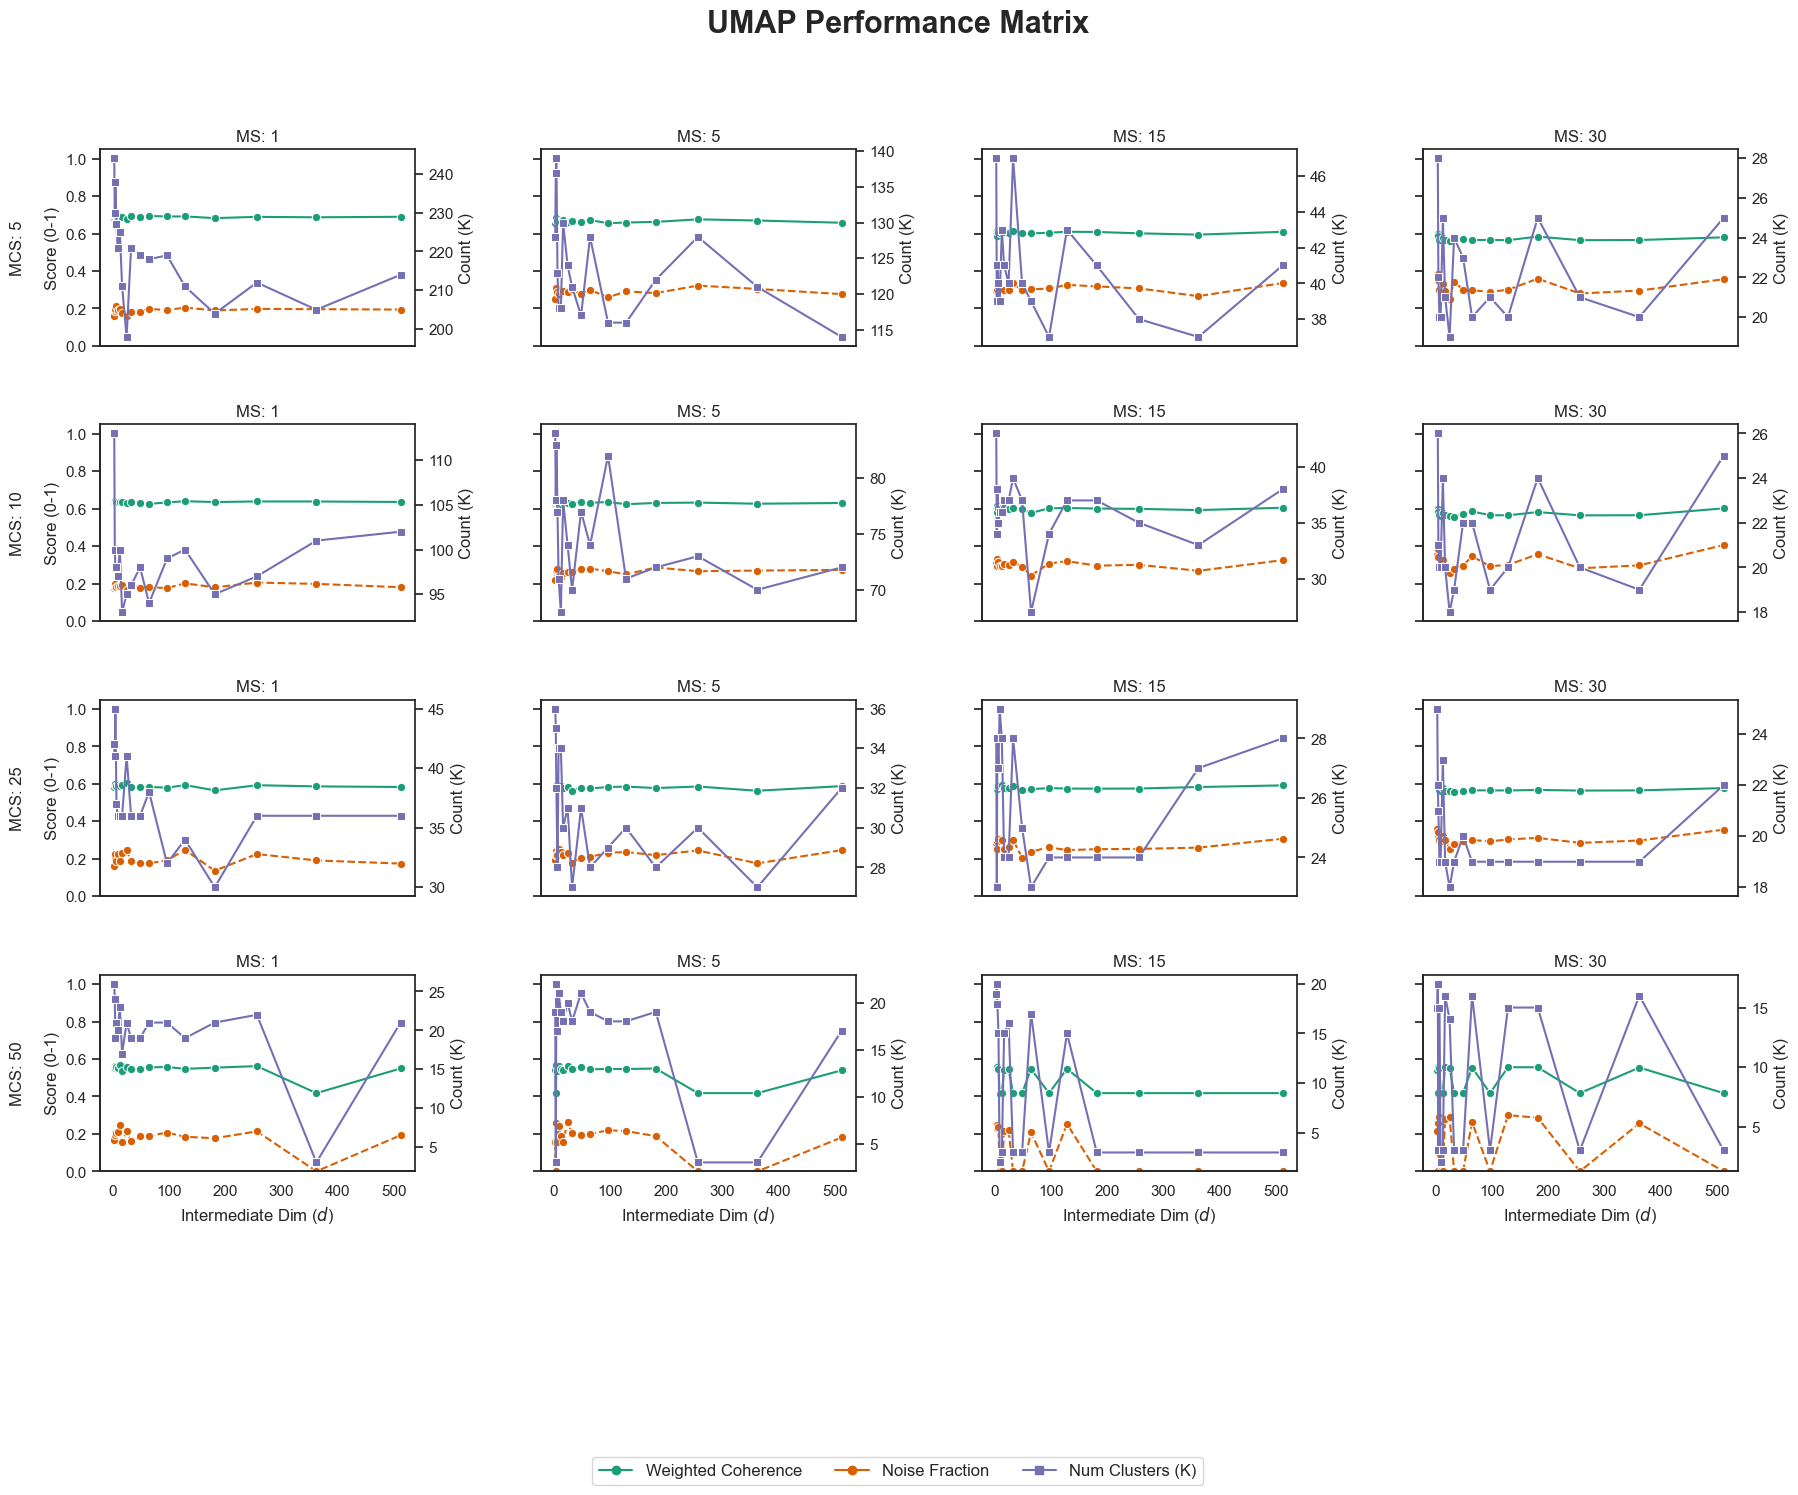

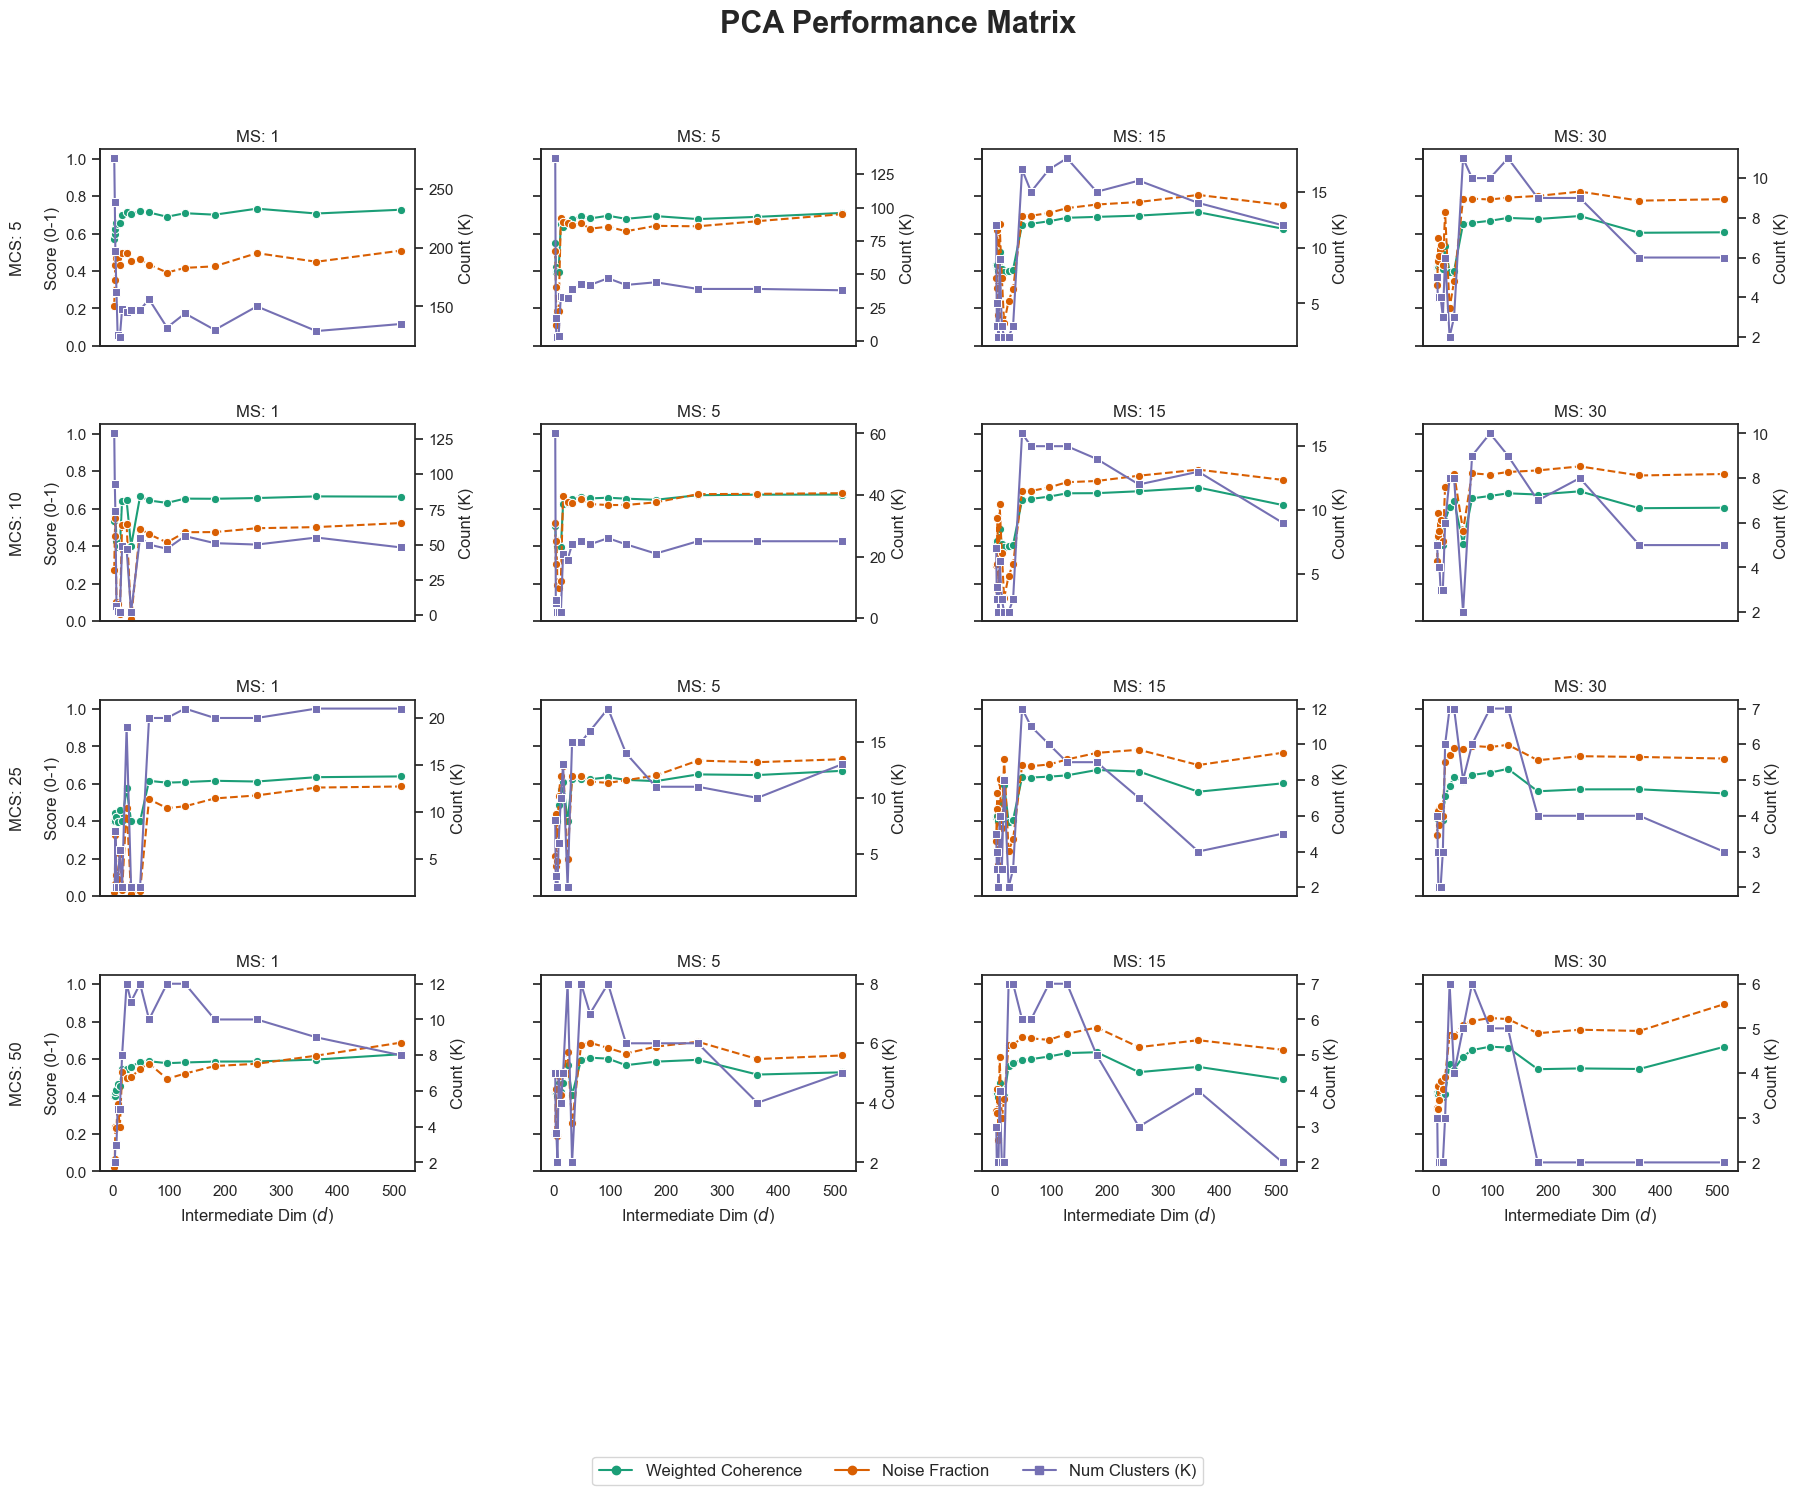

In [12]:
# Exclude d = 500
filt = final_df[final_df['d'] != 500]


# Using your professional palette
PALETTE = {"coh": "#1b9e77", "noise": "#d95f02", "k": "#7570b3"}

def twin_lineplot(data, **kwargs):
    ax1 = plt.gca()
    
    # 1. Primary Axis: Coherence and Noise
    sns.lineplot(data=data, x="d", y="weighted_coh", color=PALETTE["coh"],
                 marker="o", label="Weighted Coherence", ax=ax1, legend=False)
    sns.lineplot(data=data, x="d", y="noise_frac", color=PALETTE["noise"],
                 marker="o", linestyle="--", label="Noise Fraction", ax=ax1, legend=False)
    
    ax1.set_ylim(0, 1.05)
    ax1.set_ylabel("Score (0-1)")

    # 2. Secondary Axis: Num Clusters
    ax2 = ax1.twinx()
    sns.lineplot(data=data, x="d", y="num_clusters", color=PALETTE["k"],
                 marker="s", label="Num Clusters (K)", ax=ax2, legend=False)
    
    ax2.set_ylabel("Count (K)")
    ax2.grid(False)

def generate_matrix(df, pipeline_name):
    pipeline_df = df[df['pipeline'] == pipeline_name].copy()
    
    # Set margin_titles=False to remove the right-side clutter
    g = sns.FacetGrid(
        pipeline_df, 
        row="mcs", 
        col="ms", 
        height=3.5, 
        aspect=1.5, 
        margin_titles=False 
    )
    
    g.map_dataframe(twin_lineplot)
    
    # 3. Explicit Axis Naming
    g.set_axis_labels("Intermediate Dim ($d$)", "Score (0-1)")
    
    # 4. Clean up Titles
    # We remove the row titles from the top of every single plot 
    # and keep them only on the far-left axes.
    for ax in g.axes.flat:
        curr_title = ax.get_title()
        if "mcs =" in curr_title:
            # Splits "mcs = 5 | ms = 1" to just "MS: 1" for the top
            new_title = curr_title.split("|")[-1].replace("ms =", "MS:").strip()
            ax.set_title(new_title)

    # 5. Add Left-Side Row Labels
    # This places the "MCS" label clearly on the left of each row
    for i, row_val in enumerate(sorted(pipeline_df['mcs'].unique())):
        g.axes[i, 0].set_ylabel(f"MCS: {row_val}\n\nScore (0-1)")

    # 6. Global Legend below the X-axis
    handles = [
        plt.Line2D([0], [0], color=PALETTE["coh"], marker='o', label='Weighted Coherence'),
        plt.Line2D([0], [0], color=PALETTE["noise"], marker='o', label='Noise Fraction'),
        plt.Line2D([0], [0], color=PALETTE["k"], marker='s', label='Num Clusters (K)')
    ]
    
    g.fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.08), 
                 ncol=3, frameon=True, fontsize=12)
    
    g.fig.subplots_adjust(top=0.88, bottom=0.15, left=0.12, right=0.9, hspace=0.4, wspace=0.4)
    g.fig.suptitle(f"{pipeline_name} Performance Matrix", fontsize=22, fontweight='bold')
    
    return g

# --- Execute ---
g_umap = generate_matrix(filt, "UMAP")
g_pca = generate_matrix(filt, "PCA")
plt.show()


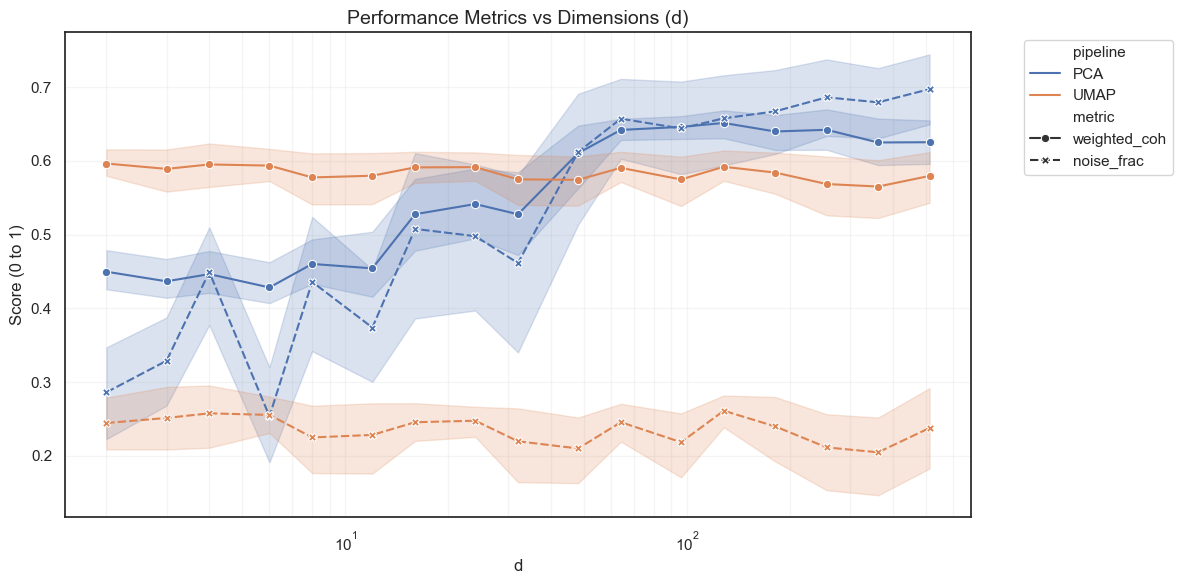

In [82]:
# 1. Filter out invalid d values (fix for the Log Scale error)
plot_df = final_df[final_df['d'] > 0].copy()

# 2. Reshape the data so 'metric' is a column
# This transforms ['weighted_coh', 'noise_frac'] into rows
melted_df = plot_df.melt(
    id_vars=['d', 'pipeline'], 
    value_vars=['weighted_coh', 'noise_frac'],
    var_name='metric', 
    value_name='value'
)

# 3. Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=melted_df, 
    x='d', 
    y='value', 
    hue='pipeline', 
    style='metric',  # Uses solid/dashed lines to distinguish metrics
    markers=True,
    dashes=True
)

# 4. Final touches
plt.xscale('log') # Use 'symlog' if you have 0s you must keep
plt.title('Performance Metrics vs Dimensions (d)', fontsize=14)
plt.ylabel('Score (0 to 1)')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

### Brief Take Aways
---
UMAP. Across the grid, UMAP produces consistently low noise fractions ≈ 0.25 while maintaining a stable weighted coherence ≈ 0.6, peaking at 0.7. The performance curves are relatively flat across intermediate dimensions, indicating that once local structure is learned, increasing 𝑑 does not materially change semantic tightness. The top-performing configurations cluster around low `min_cluster_size` (5) and low `min_samples` (1), suggesting that UMAP’s neighborhood preservation allows HDBSCAN to safely operate in a permissive regime without collapsing into noise. Even if cluster coherence seems to stay high at permisive hyper parameters, this could be due to fragmentation - where small/dense clusters dominate and inflate cluster coherence.

PCA. PCA achieves higher peak weighted coherence of 0.73 (closely tailed by UMAP), but at the cost of substantially higher noise fractions (especially at high intermediate dimension). As intermediate dimension increases, both coherence and noise tend to rise, indicating that PCA sharpens dense cores while simultaneously ejecting peripheral points. The resulting cluster counts are lower, suggesting that PCA favors fewer, tighter clusters with stricter density thresholds. This behavior reflects PCA’s global variance compression, which amplifies density contrast but fragments coverage.

Comparison. The two pipelines reflect a structural trade-off: Both pipelines can achieve similar cluster coherence, except at different tradeoffs. PCA maximizes semantic purity by discarding a large portion of the dataset, while UMAP preserves coverage and yields more clusters with potentially better granularity (but also risk of fragmentation). Both pipelines can achieve similar weighted coherence, but PCA will often produce larger and less clusters than the UMAP pipeline (under the same HDBSCAN hyperparameters). In effect, PCA behaves as a conservative filter that isolates strong thematic cores, whereas UMAP functions as an inclusive manifold-preserving reducer that supports granular trend detection. The optimal choice depends on objective: if minimizing noise is critical, UMAP dominates; if maximizing intra-cluster coherence is paramount and noise is acceptable, PCA may be preferable.

*personally, i find that umap's topological manipulation compliments HDBSCAN's density parameters, and ultimately can capture the granularity of news trends*

### Methodology Part II: Comparative Pipeline Evaluation and Stability Analysis
---

__1. Cross-Pipeline Evaluation__

To determine the superior dimensionality reduction strategy, we compare the optimized PCA and UMAP pipelines. This comparison weighs the trade-off between internal semantic density and topological robustness.

- __Relative Coherence Gain__: The percentage difference in $\text{coh}_{weighted}$ between PCA and UMAP.
- __Granularity__: A comparison of $K_{pca}$ versus $K_{umap}$ to identify which method captures a more nuanced topic hierarchy.
- __Case-by-case observations__: View select clusters by hand and document observervations.

__2. Stability Analysis via Subsampling__

To ensure the discovered clusters represent robust semantic structures rather than stochastic one-offs, we perform a stability stress test.

__2.1__ Subsampling Procedure

We perform $M$ iterations of subsampling without replacement.

- In each iteration $m$, a subset $I_m \subset I$ is drawn such that $|I_m| = 0.8N$.
- We then run the optimized PCA and UMAP pipelines for each iteration.

*_Subsampling without replacement is critical to prevent "artificial coherence" caused by identical vector duplicates, which would otherwise bias the cosine similarity scores._

__2.2__ Consistency Metrics

For each iteration $m$, we re-calculate and track metrics like _relative coherence gain_, $K$, $\text{coh}_{weighted}$. After all M iterations we observe:
    
- __Cluster Count Variance__ ($\sigma^2_K$): Measures the decisiveness of the pipeline.
$$
\sigma^2_K = \frac{1}{M-1} \sum_{m=1}^{M} (K_m - \bar{K})^2
$$

- __Coherence Stability__: The standard deviation of $\text{coh}_{weighted}$ across runs, indicating if the "thematic tightness" is dependent on specific articles.



$$
\sigma_{\text{coh}_{weighted}} = \sqrt{\frac{1}{M-1} \sum_{m=1}^{M} ({\text{coh}_{weighted}}_m - {\text{coh}_{weighted}}_{avg})^2}
$$

- __Adjusted Rand Index (ARI)__: The primary measure of __Label Persistence__. For the set of points present in both the original run (labels $L_{orig}$) and the subsampled run (labels $L_m$), we calculate:

$$ARI(L_{orig}, L_m) = \frac{\sum_{ij} \binom{n_{ij}}{2} - [\sum_i \binom{a_i}{2} \sum_j \binom{b_j}{2}] / \binom{n}{2}}{\frac{1}{2} [\sum_i \binom{a_i}{2} + \sum_j \binom{b_j}{2}] - [\sum_i \binom{a_i}{2} \sum_j \binom{b_j}{2}] / \binom{n}{2}}$$
- An $ARI \approx 1.0$ indicates perfect cluster survival.
- An $ARI \approx 0$ indicates that the clusters are essentially random and do not persist across data perturbations.

### References